In [1]:
# %% [markdown]
# # Minerva-350M “Toscano Arcaico → Modern Italian” Fine-Tuning & LIMA Instruction-Tuning
#
# **Notebook Overview**
#
# In this notebook, we will:
# 1. Install and import necessary dependencies.
# 2. Load the Minerva-350M model from Hugging Face (`sapienzanlp/Minerva-350M-base-v1.0`) and its tokenizer.
# 3. Prepare a “Toscano arcaico → Modern Italian” translation dataset (e.g., `divina_commedia.csv`).
# 4. Fine-tune Minerva-350M on that translation task.
# 5. Load the LIMA instruction dataset directly from Hugging Face and format it for causal-LM instruction tuning.
# 6. Continue training (instruction-tuning) with LIMA.
# 7. Save the final combined model.
#
# You can run each cell in sequence. Adjust paths, hyperparameters, and file names as needed.

# %% [markdown]
## 1. Install & Import Dependencies

# %%
# !pip install transformers datasets pandas torch --quiet

In [ ]:
import os
import logging
from pathlib import Path

import pandas as pd
from datasets import Dataset, DatasetDict, load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    default_data_collator,
)
from huggingface_hub import login
login("token")

# Set up simple logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

/home/chris/.miniconda/envs/mnlphw2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %% [markdown]
## 2. Configuration & Hyperparameters

# %%
# Model & Paths
MODEL_ID        = "sapienzanlp/Minerva-350M-base-v1.0"
TRANSLATION_CSV = "divina_commedia.csv"   # Path to your local CSV with columns: Cantico, Canto, Terzetto, Original, Translation
OUTPUT_DIR      = "./minerva_toscano_TRANSLATE_notebook"

# Training Hyperparameters for Translation
TRANSLATE_BATCH_SIZE    = 6
TRANSLATE_EPOCHS        = 3
TRANSLATE_LEARNING_RATE = 5e-5
MAX_SOURCE_LENGTH       = 512
MAX_TARGET_LENGTH       = 512

# Training Hyperparameters for Instruction Tuning (LIMA)
TRANSLATE_BATCH_SIZE         = 4
LIMA_EPOCHS             = 2
LIMA_LEARNING_RATE      = 3e-5
MAX_INSTR_LENGTH        = 512

# Make sure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
# %% [markdown]
## 3. Load Minerva-350M Model & Tokenizer

# %%
logger.info("Loading Minerva-350M model and tokenizer from Hugging Face…")

model = AutoModelForCausalLM.from_pretrained(MODEL_ID)
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

tokenizer.pad_token = tokenizer.eos_token

INFO:__main__:Loading Minerva-350M model and tokenizer from Hugging Face…


In [4]:
# %% [markdown]
## 4. Prepare “Toscano arcaico → Modern Italian” Translation Dataset

# %%
logger.info("Loading and preprocessing the translation dataset…")

def load_translation_dataset(csv_path: str) -> DatasetDict:
    """
    Reads a CSV with columns: Cantico, Canto, Terzetto, Original, Translation.
    We only need the “Original” (Toscano arcaico) and “Translation” (Modern Italian) columns.
    Returns a Hugging Face DatasetDict with a single 'train' split.
    """
    path = Path(csv_path)
    if not path.is_file():
        raise FileNotFoundError(f"Dataset not found at: {path.resolve()}")
    
    df = pd.read_csv(csv_path)
    df = df[["Original", "Translation"]].dropna().reset_index(drop=True)
    df = df.rename(columns={"Original": "source_text", "Translation": "target_text"})
    hf_dataset = Dataset.from_pandas(df)
    return DatasetDict({"train": hf_dataset})

translation_datasets = load_translation_dataset(TRANSLATION_CSV)

def preprocess_translation_examples(examples):
    """
    For a causal LM, we concatenate:
      "Translate Toscano arcaico to Modern Italian:\n{source_text}\nModern:\n{target_text}"
    Tokenize that whole string, then mask out prompt tokens (labels=-100) so loss is computed only on the target.
    """
    input_ids_list = []
    attention_masks = []
    labels_list    = []

    for src, tgt in zip(examples["source_text"], examples["target_text"]):
        # prompt = (
        #     "Translate Toscano arcaico to Modern Italian:\n"
        #     f"{src}\n"
        #     "Modern:\n"
        # )

        prompt = (
            f"<start_of_turn>user\n"
            f"Traduci solo questa frase da italiano antico a italiano moderno. "
            f"Rispondi solo con la frase tradotta, senza commenti o formattazione aggiuntiva:\n"
            f"{src}\n"
            f"<end_of_turn>\n<start_of_turn>model\n"
        )

        full_text = prompt + tgt

        tokenized_full = tokenizer(
            full_text,
            truncation=True,
            max_length=MAX_SOURCE_LENGTH + MAX_TARGET_LENGTH,
            padding="max_length",
        )
        input_ids     = tokenized_full["input_ids"]
        attention_mask= tokenized_full["attention_mask"]

        # Tokenize only the target to get its length (without special tokens)
        tgt_tokenized = tokenizer(
            tgt, truncation=True, max_length=MAX_TARGET_LENGTH, add_special_tokens=False
        )["input_ids"]
        tgt_len = len(tgt_tokenized)

        # Build labels: first (len(input_ids) - tgt_len) tokens are -100, last tgt_len are the actual target IDs
        labels_ids = [-100] * (len(input_ids) - tgt_len) + tgt_tokenized
        # If padding caused label list to be shorter, pad with -100
        if len(labels_ids) < len(input_ids):
            labels_ids += [-100] * (len(input_ids) - len(labels_ids))

        input_ids_list.append(input_ids)
        attention_masks.append(attention_mask)
        labels_list.append(labels_ids)

    return {
        "input_ids": input_ids_list,
        "attention_mask": attention_masks,
        "labels": labels_list,
    }

translation_tokenized = translation_datasets["train"].map(
    preprocess_translation_examples,
    batched=True,
    remove_columns=["source_text", "target_text"],
    desc="Tokenizing translation dataset",
)

INFO:__main__:Loading and preprocessing the translation dataset…
Tokenizing translation dataset: 100%|██████████| 2379/2379 [00:01<00:00, 2116.21 examples/s]


In [5]:
from transformers import TrainingArguments, Trainer

translation_args = TrainingArguments(
    output_dir=f"{OUTPUT_DIR}/translation",
    per_device_train_batch_size=TRANSLATE_BATCH_SIZE,
    num_train_epochs=TRANSLATE_EPOCHS,
    learning_rate=TRANSLATE_LEARNING_RATE,
    weight_decay=0.01,
    save_strategy="epoch",
    save_total_limit=2,
    logging_dir=f"{OUTPUT_DIR}/logs",
    logging_strategy="steps",
    logging_steps=50,
    remove_unused_columns=False,
    report_to="none",
    fp16=True,            # enable mixed precision (faster on most GPUs with tensor cores)
)

trainer_translation = Trainer(
    model=model,
    args=translation_args,
    train_dataset=translation_tokenized,
    data_collator=default_data_collator,
)

trainer_translation.train()
trainer_translation.save_model(f"{OUTPUT_DIR}/translation_checkpoint")


Step,Training Loss
50,3.109400
100,2.879300
150,2.786100
200,2.831000
250,2.625200
300,2.680900
350,2.580500
400,2.522500
450,1.201200
500,1.188700


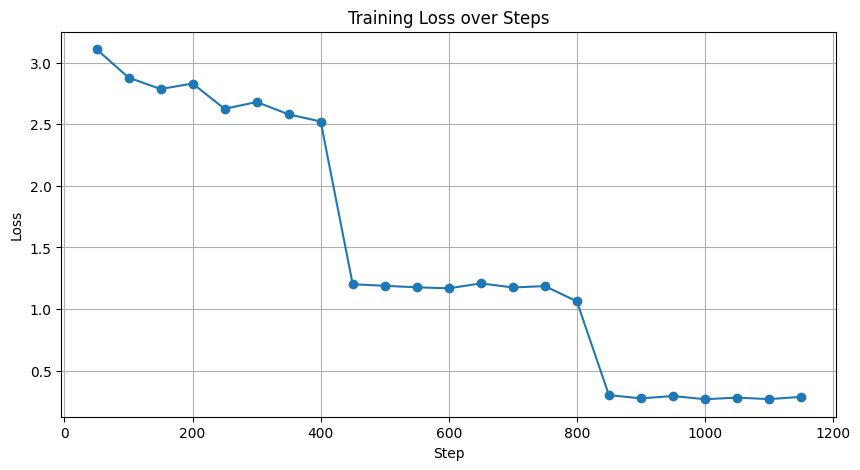

In [6]:
import matplotlib.pyplot as plt

# Extract log history from the trainer
log_history = trainer_translation.state.log_history

# Filter out training loss entries
loss_values = [entry["loss"] for entry in log_history if "loss" in entry]
steps = [entry["step"] for entry in log_history if "loss" in entry]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(steps, loss_values, marker="o", linestyle="-")
plt.title("Training Loss over Steps")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [7]:
# %% [markdown]
## 6. Load & Preprocess LIMA Instruction Dataset
import json

# %%
logger.info("Loading LIMA dataset from Hugging Face…")

# The LIMA dataset is available under "GAIR/lima"
lima_raw = load_dataset("GAIR/lima")

def preprocess_lima_examples(examples):
    input_ids_list = []
    attention_masks = []
    labels_list = []

    valid_count = 0
    skipped_format = 0
    malformed_json = 0

    for idx, conv in enumerate(examples["conversations"]):
        if isinstance(conv, str):
            try:
                conv = json.loads(conv)
            except json.JSONDecodeError:
                malformed_json += 1
                print(f"[Warning] Malformed JSON at index {idx}")
                continue

        if not isinstance(conv, list) or len(conv) < 2:
            skipped_format += 1
            print(f"[Warning] Invalid format (not a list or too short) at index {idx}")
            continue

        instr = conv[0].strip()
        resp = conv[1].strip()

        prompt = f"Instruction: {instr}\nResponse:\n"
        full_text = prompt + resp

        tokenized_full = tokenizer(
            full_text,
            truncation=True,
            max_length=MAX_INSTR_LENGTH,
            padding="max_length",
        )
        input_ids = tokenized_full["input_ids"]
        attention_mask = tokenized_full["attention_mask"]

        resp_tokenized = tokenizer(
            resp,
            truncation=True,
            max_length=(MAX_INSTR_LENGTH // 2),
            add_special_tokens=False,
        )["input_ids"]
        resp_len = len(resp_tokenized)

        labels_ids = [-100] * (len(input_ids) - resp_len) + resp_tokenized
        if len(labels_ids) < len(input_ids):
            labels_ids += [-100] * (len(input_ids) - len(labels_ids))

        input_ids_list.append(input_ids)
        attention_masks.append(attention_mask)
        labels_list.append(labels_ids)

        valid_count += 1

    return {
        "input_ids": input_ids_list,
        "attention_mask": attention_masks,
        "labels": labels_list,
    }



lima_tokenized = lima_raw["train"].map(
    preprocess_lima_examples,
    batched=True,
    remove_columns=["conversations", "source"],
    desc="Tokenizing LIMA dataset",
)



INFO:__main__:Loading LIMA dataset from Hugging Face…
Tokenizing LIMA dataset: 100%|██████████| 1030/1030 [00:01<00:00, 586.39 examples/s]


In [8]:
# %% [markdown]
## 7. Instruction-Tune Minerva with LIMA

# %%
logger.info("Starting instruction-tuning with LIMA…")

lima_args = TrainingArguments(
    output_dir=f"{OUTPUT_DIR}/lima",
    per_device_train_batch_size=TRANSLATE_BATCH_SIZE,
    num_train_epochs=TRANSLATE_EPOCHS,
    learning_rate=TRANSLATE_LEARNING_RATE,
    weight_decay=0.01,
    logging_steps=50,
    save_steps=500,
    save_total_limit=2,
    remove_unused_columns=False,
    fp16=True,
)

trainer_lima = Trainer(
    model=model,  # continues from translation-tuned weights
    args=lima_args,
    train_dataset=lima_tokenized,
    data_collator=default_data_collator,
)

trainer_lima.train()
trainer_lima.save_model(f"{OUTPUT_DIR}/final_minerva_toscano_lima")


INFO:__main__:Starting instruction-tuning with LIMA…


Step,Training Loss
50,6.717800
100,6.006500
150,5.756400
200,5.388300
250,4.898900
300,5.012600
350,4.885000
400,4.246100
450,4.063000
500,4.073400


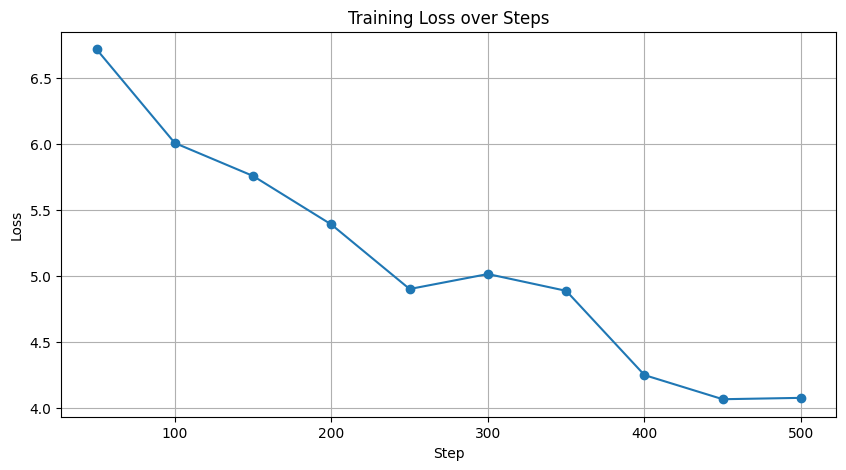

In [9]:
# Extract log history from the trainer
log_history = trainer_lima.state.log_history

# Filter out training loss entries
loss_values = [entry["loss"] for entry in log_history if "loss" in entry]
steps = [entry["step"] for entry in log_history if "loss" in entry]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(steps, loss_values, marker="o", linestyle="-")
plt.title("Training Loss over Steps")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [10]:
# %% [markdown]
## 8. Save Final Model & Tokenizer

# %%
logger.info("Saving final model and tokenizer…")

model.save_pretrained(f"{OUTPUT_DIR}/final_minerva_toscano_lima")
tokenizer.save_pretrained(f"{OUTPUT_DIR}/final_minerva_toscano_lima")

logger.info("All done! Model saved under: %s", os.path.join(OUTPUT_DIR, "final_minerva_toscano_lima"))

# %% [markdown]
## 9. Example Inference (Optional)
#
# Once training is complete, you can reload the model for inference:
#
# ```python
# from transformers import AutoTokenizer, AutoModelForCausalLM
#
# tokenizer = AutoTokenizer.from_pretrained("./minerva_toscano_lima_notebook/final_minerva_toscano_lima")
# model     = AutoModelForCausalLM.from_pretrained("./minerva_toscano_lima_notebook/final_minerva_toscano_lima")
#
# prompt = (
#     "Translate Toscano arcaico to Modern Italian:\n"
#     "Nel mezzo del cammin di nostra vita mi ritrovai per una selva oscura ché la diritta via era smarrita.\n"
#     "Modern:\n"
# )
# inputs = tokenizer(prompt, return_tensors="pt")
# outputs = model.generate(**inputs, max_new_tokens=128)
# print(tokenizer.decode(outputs[0], skip_special_tokens=True))
# ```


INFO:__main__:Saving final model and tokenizer…
INFO:__main__:All done! Model saved under: ./minerva_toscano_lima_notebook/final_minerva_toscano_lima


In [13]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Load model and tokenizer from the saved directory
model_path = "./minerva_toscano_lima_notebook/final_minerva_toscano_lima"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path)
model.eval()  # Set model to evaluation mode

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define an example prompt
src = "Ora spaventerai li disidirosi cervi con varie e diverse paure, o lo porco cenghiare caggia in terra passato collo spiedo."
prompt = (
            f"<start_of_turn>user\n"
            f"Traduci solo questa frase da italiano antico a italiano moderno. "
            f"Rispondi solo con la frase tradotta, senza commenti o formattazione aggiuntiva:\n"
            f"{src}\n"
            f"<end_of_turn>\n<start_of_turn>model\n"
        )

# Tokenize and generate
inputs = tokenizer(prompt, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=128,
        do_sample=True,
        temperature=0.5,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id

    )

# Decode and print the output
output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("\n📝 Generated Output:\n")
print(output_text)



📝 Generated Output:

<start_of_turn>user
Traduci solo questa frase da italiano antico a italiano moderno. Rispondi solo con la frase tradotta, senza commenti o formattazione aggiuntiva:
Ora spaventerai li disidirosi cervi con varie e diverse paure, o lo porco cenghiare caggia in terra passato collo spiedo.
<end_of_turn>
<start_of_turn>model
 Oraterri gli scellerati con gli occhi diversi e con diverse paure o con gli stessi sensi, o lo curtocchino cinghiale in terra con gli occhi diversi [da quelli scellerati], che causano l’apo, o scellerato, cinghiale cinghiale, o scellerato, cinghiale, o scellerato, os, o scellerato, os o scellerato, con gli occhi diversi dal capo scellerato o scellerato, o scellerato, o scellerato, oscurosi cinghiale [ in terrac


In [7]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from tqdm import tqdm

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define models
FINETUNED_PATH = "./minerva_toscano_lima_notebook/final_minerva_toscano_lima"


# Prompt template
def build_prompt(sentence):
    return (
        "Translate just this sentence from archaic italian to modern italian.\n"
        "Answer with just the translated sentence, NO COMMENTS or ADDED FORMATTING.\n"
        f"Sentence:\n{sentence}\nTranslation:\n"
    )

# Inference function
def generate_translation(model, tokenizer, sentence):
    prompt = build_prompt(sentence)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=True,
            temperature=0.5,
            top_p=0.9,
            repetition_penalty=1.1,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    translation = decoded.split("Translation:\n")[-1].strip()
    return translation

# Load CSV
df = pd.read_csv("dataset_cleaned.csv")

# Sanity check
if "Sentence" not in df.columns:
    raise ValueError("❌ 'Sentence' column not found in CSV!")

df = df.head(20)  # Optional: limit to 20 for quick test

# Load tokenizers and models
print("🔄 Loading models...")

# Finetuned
tokenizer_fine = AutoTokenizer.from_pretrained(FINETUNED_PATH)
model_fine = AutoModelForCausalLM.from_pretrained(FINETUNED_PATH).to(device).eval()
tokenizer_fine.pad_token = tokenizer_fine.pad_token or tokenizer_fine.eos_token

# Base
tokenizer_base = AutoTokenizer.from_pretrained(MODEL_ID)
model_base = AutoModelForCausalLM.from_pretrained(MODEL_ID).to(device).eval()
tokenizer_base.pad_token = tokenizer_base.pad_token or tokenizer_base.eos_token

# Translate
results = []
print("🧠 Translating sentences...")
for sentence in tqdm(df["Sentence"]):
    fine_translation = generate_translation(model_fine, tokenizer_fine, sentence)
    base_translation = generate_translation(model_base, tokenizer_base, sentence)
    results.append({
        "input": sentence.strip(),
        "finetuned_translation": fine_translation,
        "base_translation": base_translation,
    })

import json

# Save to JSONL
output_path = "translated_results.jsonl"
with open(output_path, "w", encoding="utf-8") as f:
    for item in results:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

print(f"✅ Results saved to {output_path}")



🔄 Loading models...
🧠 Translating sentences...


100%|██████████| 20/20 [01:04<00:00,  3.22s/it]

✅ Results saved to translated_results.jsonl
